# Ingredient Scanner

In this notebook, we develop an app that identifies the safety of the ingredients in a product using EWG's Skindeep database via Cosmily's API, computer vision and optical character recognition (OCR).

By implementing Google's tesseract, an OCR tool used to automate data extraction, and OpenCV (Open Source Computer Vision Library), a real-time image processing library, we are able to scan images of ingredient lists on products and extract the text in the images for analysis. 

### Resources:
* EWG's Skindeep Database: https://www.ewg.org/skindeep/
* OpenCV: https://opencv.org/
* Tesseract: https://github.com/tesseract-ocr/tesseract
* pytesseract: https://pypi.org/project/pytesseract/
* Cosmily API: https://docs.cosmily.com/


In [2]:
from config import *
import cv2
import pytesseract
import re
from nltk.corpus import stopwords
import requests
import pandas as pd

## Image-to-Text Conversion and Extraction
We begin by defining the file path of an image that depicts a list of ingredients, which in this case is a bottle of Sensodyne toothpaste.

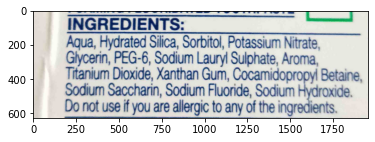

In [3]:
image_path = './images/sensodyne.png'

# PNG files can be shown as such:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.imshow(mpimg.imread(image_path))
plt.show()

Next, we convert the image to text by reading the image file and transforming it into an RGB image. In combination with regex, we implement tesseract to extract the text from the RGB image to a list of strings without punctuation.

In [6]:
def convert_image_to_text(path):
    # open image and convert to rgb
    img = cv2.imread(path)
    b,g,r = cv2.split(img)
    img_rgb = cv2.merge([r,g,b])

    # convert image to string
    return re.findall(r'[^.,:/\n]+', pytesseract.image_to_string(img_rgb))

text = convert_image_to_text(image_path)
text

['INGREDIENTS',
 ' an',
 'Aqua',
 ' Hydrated Silica',
 ' Sorbitol',
 ' Potassium Nitrate',
 'Glycerin',
 ' PEG-6',
 ' Sodium Lauryl Sulphate',
 ' Aroma',
 'Titanium Dioxide',
 ' Xanthan Gum',
 ' Cocamidopropyi Betaine',
 'Sodium Saccharin',
 ' Sodium Fluoride',
 ' Sodium Hydroxide',
 'Do not use if you are allergic to any of the ingredients']

## Data Cleaning

Here, we clean the data by removing any stop words (articles, prepositions, etc.) via NLTK, miscellaneous text, leading spaces, and the word "ingredients". Afterwards, we should have a list solely comprised of the product's ingredients.

In [8]:
def preprocess(text):
    stop_words = set(stopwords.words('english'))
    ingredients_list = []

    # remove stop words, the word "ingredients", and leading spaces
    for item in text:
        item = item.lstrip()
        if "ingredients" not in item.lower() and item not in stop_words:
            ingredients_list.append(item)

    ingredients = ', '.join(ingredients_list)
    return ingredients

ingredients = preprocess(text)
ingredients

'Aqua, Hydrated Silica, Sorbitol, Potassium Nitrate, Glycerin, PEG-6, Sodium Lauryl Sulphate, Aroma, Titanium Dioxide, Xanthan Gum, Cocamidopropyi Betaine, Sodium Saccharin, Sodium Fluoride, Sodium Hydroxide'

# Analysis

In order to attain access to EWG's Skindeep database and safety analysis of each ingredient, we utilize Cosmily's API and pass our list of ingredients as a parameter.

In [10]:
def analyze(ingredients):
    # get analysis of ingredient list from cosmily database api
    api_url = 'https://api.cosmily.com/api/v1/analyze/ingredient_list'
    headers =  {"Content-Type":"application/json", "Authorization": AUTH_TOKEN}
    params = {"ingredients": ingredients}
    response = requests.post(api_url, params=params, headers=headers)
    return response.json()['analysis']

analysis = analyze(ingredients)
analysis

{'total_ingredients': 14,
 'ingredients_table': [{'index': 1,
   'title': 'Aqua',
   'alias': 'water',
   'id': 1,
   'introtext': "<p>#1 <strong>solvent</strong> in many skincare and haircare products. Usually, creams contain 40 - 70% of water, while toners and micellar water may have up to 90%. Manufacturers <strong>purify</strong> and <strong>deionize</strong> it before putting it into the product to make the formula last longer.</p> <p>As for the benefits, it is neither good nor bad. It's a neutral component itself, but it's a very important part of a product.</p>",
   'cir_rating': '',
   'boolean_properties': {},
   'integer_properties': {'comedogenic_rating': 0, 'natural': 1},
   'ewg': {'url': '/skindeep/ingredient/706945/WATER/',
    'min': 1,
    'max': 1,
    'data': 'Robust',
    'background': 'bg-safe',
    'decision': 'Safe'},
   'categories': 'Solvent'},
  {'index': 2,
   'title': 'Hydrated Silica',
   'alias': 'hydrated-silica',
   'id': 56,
   'introtext': '',
   'cir_

## Main Findings
To get a better understanding of the effect each ingredient can have on our bodies, we focus on the safety, benefits and hazards of each ingredient.

In [32]:
print(analysis['description'])
print(f"{analysis['text'].split('. ')[1]}.")

The product contains 14 ingredients. INCI: Aqua, Hydrated Silica, Sorbitol, and more. We have found polyethylene glycol (PEG), synthetic fragrances.
It's free of: Allergens, harmful alcohols, comedogenic components, Gluten, Silicones, Sulfates, Parabens, fungal acne feeding components.


### Safety of Ingredients

By filtering through the "ingredients_table" in the analysis, we explore EWG's safety rating for each of the ingredients.

In [33]:
ingredients_dictlist = []
ingdf = pd.DataFrame(columns=['Name','Alias','Decision'])

ings = []
ali = []
decis = []
for ing in analysis['ingredients_table']:
    ingredients_dictlist.append(ing)
    ings.append(ing['title'])
    ali.append(ing['alias'])
    
    try:
        ing['ewg']['decision']
    except:
        decis.append('N/A')
    else:
        decis.append(ing['ewg']['decision'])


ingdf['Name'] = ings
ingdf['Alias'] = ali
ingdf['Decision'] = decis

ingdf

,Name,Alias,Decision
0,Aqua,water,Safe
1,Hydrated Silica,hydrated-silica,Safe
2,Sorbitol,sorbitol,Safe
3,Potassium Nitrate,potassium-nitrate,Safe
4,Glycerin,glycerin,Safe
5,PEG-6,peg-6,Safe - Moderate hazard
6,Sodium Lauryl Sulphate,None,N/A
7,Aroma,fragrance,High hazard
8,Titanium Dioxide,titanium-dioxide,Safe - Moderate hazard
9,Xanthan Gum,xanthan-gum,Safe


### Beneficial Aspects

Then, we assess the beneficial aspects of certain ingredients, including:
* Moisturizing
* Softening
* Soothing
* Antiseptic
* UV Protection

In [24]:
pos_df = pd.DataFrame(columns=['Benefit','Ingredient','Description'])

pos = []
desc = []
ings = []
for positive in analysis['positive']:
    pos.append(analysis['positive'][positive]['title'])
    desc.append(analysis['positive'][positive]['description'])
    ings.append(analysis['positive'][positive]['list'][0]['title'])

pos_df['Benefit'] = pos
pos_df['Ingredient'] = ings
pos_df['Description'] = desc

pos_df

,Benefit,Ingredient,Description
0,Moisturising,Sorbitol,Hydrates the skin
1,Softening,Sorbitol,Improves texture
2,Soothing,Sorbitol,Reduces irritation
3,Antiseptic,Xanthan Gum,Kills bacteria
4,UV Protection,Titanium Dioxide,Blocks sun damage


### Hazardous Aspects

Finally, we identify whether ingredients possess the following hazardous aspects:
* Allergens
* Alcohols
* Comedogenic (Acne) Components
* Gluten
* Silicones
* Parabens 
* PEGs
* Carcinogens
* Fungal Acne Feeding Components
* Fragrance

In [46]:
harm_df = pd.DataFrame(columns=['Hazard','Ingredient','Description'])
name = []
desc = []
ings = []
for h in analysis['harmful']:
    if len(analysis['harmful'][h]['list']) > 0:
        for i in analysis['harmful'][h]['list']:
            name.append(analysis['harmful'][h]['title'])
            desc.append(analysis['harmful'][h]['description'])
            ings.append(i['title'])

harm_df['Hazard'] = name
harm_df['Ingredient'] = ings
harm_df['Description'] = desc

harm_df

,Hazard,Ingredient,Description
0,PEG,PEG-6,Polyethylene glycol
1,Fragrance,Aroma,Complex chemicals


# Conclusion
By automating the tedious and time-consuming process of individually checking ingredients for harmful toxins, we have the ability to make informed and safer choices in our everyday lives. We found our ingredient scanner was able to accurately detect all 14 ingredients listed on the back of the Sensodyne toothpaste bottle and return a comprehensive analysis of each ingredient using the Cosmily API. In the future, we aim to expand our app to include a GUI for users to upload images, as well as, better display our results. Furthermore, our goal is to utilize OpenCV and its image processing capabilites to allow users to take and analyze photos in real-time at any location.